# Übungsblatt 3 - Exercise 3a


In [2]:
#setup
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_absolute_error

import tensorflow as tf

In [3]:
#import data
data = pd.read_csv("./data_gemini_BTCUSD_1hr.csv")
data.head()


,Unix Timest;amp,Date,Symbol,Open,High,Low,Close,Volume
0,15906240000;00,2020-05-28 00:00:00,BTCUSD,9210.00,9210.00,9197.26,9201.03,1.152280
1,15906204000;00,2020-05-27 23:00:00,BTCUSD,9099.18,9210.00,9093.28,9210.00,58.280048
2,15906168000;00,2020-05-27 22:00:00,BTCUSD,9062.91,9132.07,9057.53,9099.18,28.786737
3,15906132000;00,2020-05-27 21:00:00,BTCUSD,9167.32,9169.73,9058.75,9062.91,108.451841
4,15906096000;00,2020-05-27 20:00:00,BTCUSD,9156.56,9177.65,9155.03,9167.32,77.673166


In [4]:
data.columns

Index(['Unix Timest;amp', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close',
       'Volume'],
      dtype='object')

Text(0.5, 1.0, 'Close')

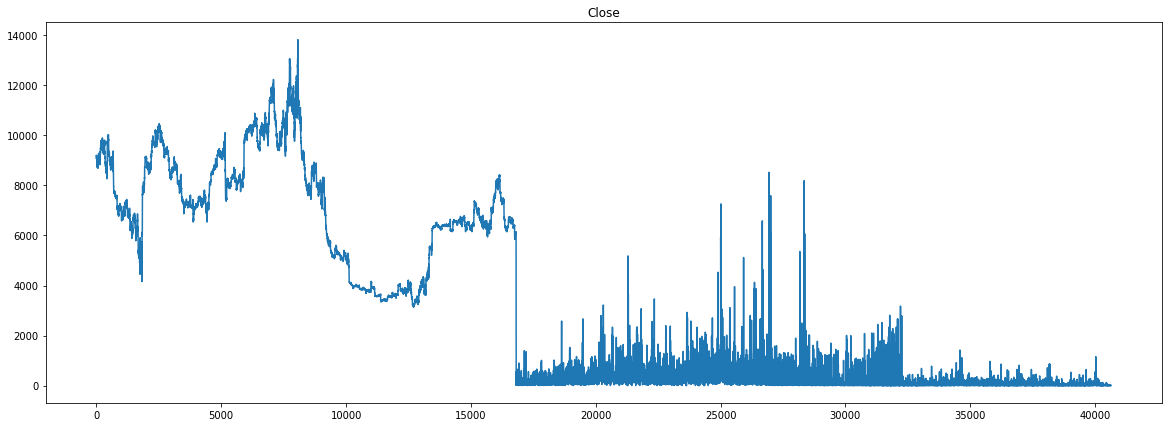

In [5]:
#plot data column "close"
plt.figure(figsize=(20,7))
plt.plot(data.Close)
plt.title("Close")

In [6]:
#scale data
time_series = data.Close.values
time_series.shape
time_series = time_series.reshape(-1, 1)
time_series = time_series.reshape(-1, 1)
scaler = MinMaxScaler()
time_series_scaled = scaler.fit_transform(time_series)

In [7]:
def ts_to_training_data(ts, n_look_back=5):
    
    from numpy import array
    
    ts = array(ts)
    i = n_look_back + 1
    
    X, y, = [], []
    
    while i < len(ts): 
        
        X.append(ts[i-n_look_back:i].reshape(n_look_back, 1))
        y.append(ts[i])
        
        i +=1
    
    
    return array(X), array(y)

In [8]:
look_back = 4

X, y = ts_to_training_data(
    time_series_scaled, 
    n_look_back=look_back)

In [9]:
#pepare Y & y data splits
X.shape, y.shape
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = X_train_full[30:], y_train_full[30:]
X_valid, y_valid = X_train_full[:30], y_train_full[:30]
train_b = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(24)
valid_b = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(24)
test_b = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(24)

In [10]:
#Create RNN Model 
model = Sequential()

model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1, activation="linear"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(
    loss=mean_squared_error, 
    optimizer=Adam(), 
    metrics=[
        mean_absolute_error
    ]
)

In [12]:
train_history = model.fit(
    train_b, 
    validation_data=valid_b, 
    epochs=100,
    verbose=2
)

test_history = model.evaluate(test_b)

Epoch 1/100
1354/1354 - 6s - loss: 0.0118 - mean_absolute_error: 0.0485 - val_loss: 0.0021 - val_mean_absolute_error: 0.0187
Epoch 2/100
1354/1354 - 5s - loss: 3.7075e-04 - mean_absolute_error: 0.0109 - val_loss: 0.0021 - val_mean_absolute_error: 0.0180
Epoch 3/100
1354/1354 - 5s - loss: 3.4863e-04 - mean_absolute_error: 0.0101 - val_loss: 0.0021 - val_mean_absolute_error: 0.0177
Epoch 4/100
1354/1354 - 5s - loss: 3.2941e-04 - mean_absolute_error: 0.0094 - val_loss: 0.0021 - val_mean_absolute_error: 0.0172
Epoch 5/100
1354/1354 - 5s - loss: 3.1630e-04 - mean_absolute_error: 0.0088 - val_loss: 0.0021 - val_mean_absolute_error: 0.0168
Epoch 6/100
1354/1354 - 6s - loss: 3.0769e-04 - mean_absolute_error: 0.0084 - val_loss: 0.0021 - val_mean_absolute_error: 0.0167
Epoch 7/100
1354/1354 - 5s - loss: 3.0183e-04 - mean_absolute_error: 0.0081 - val_loss: 0.0021 - val_mean_absolute_error: 0.0166
Epoch 8/100
1354/1354 - 5s - loss: 2.9768e-04 - mean_absolute_error: 0.0079 - val_loss: 0.0021 - val_

Text(0.5, 1.0, 'Mean Absolute Error')

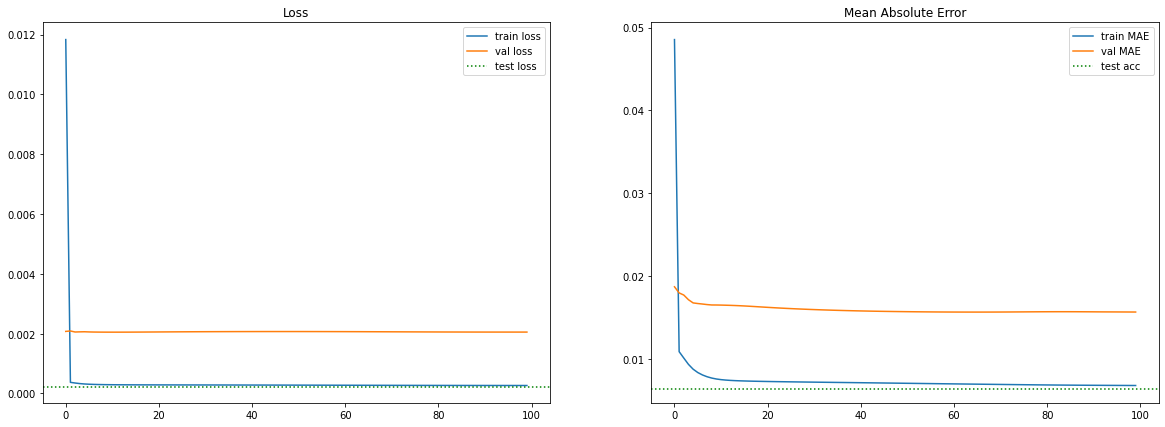

In [13]:
#plot training 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

ax[0].plot(train_history.history["loss"], label="train loss")
ax[0].plot(train_history.history["val_loss"], label="val loss")
ax[0].axhline(
    y=test_history[0],
    xmin=0,
    xmax=len(train_history.history["loss"]),
    color="green",
    ls=":",
    label="test loss"
)
ax[0].legend(loc=0)
ax[0].set_title("Loss")

ax[1].plot(train_history.history["mean_absolute_error"], label="train MAE")
ax[1].plot(train_history.history["val_mean_absolute_error"], label="val MAE")
ax[1].axhline(
    y=test_history[1],
    xmin=0,
    xmax=len(train_history.history["mean_absolute_error"]),
    color="green",
    ls=":",
    label="test acc"
)
ax[1].legend(loc=0)
ax[1].set_title("Mean Absolute Error")

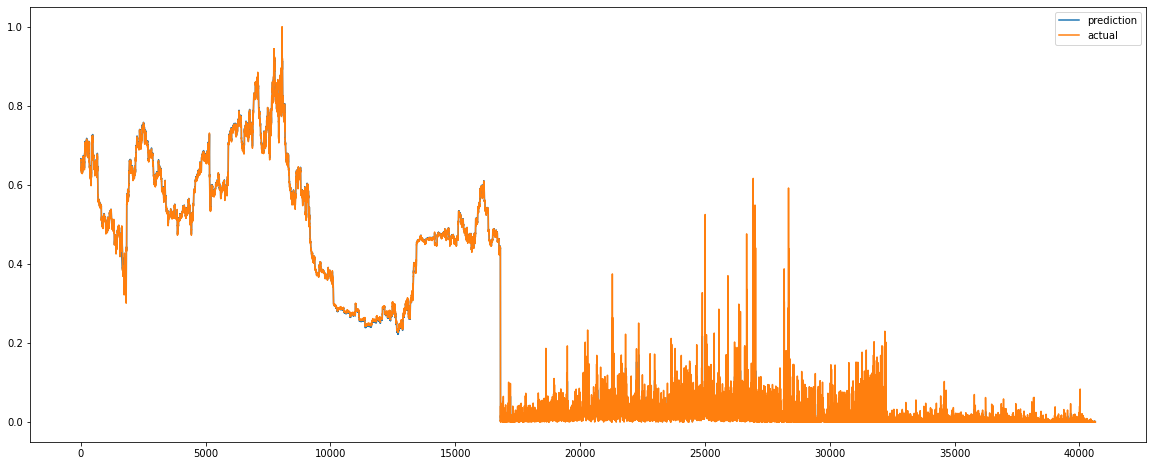

In [14]:
#predict and show results 
y_predicted = model.predict(X)
plt.figure(figsize=(20,8))
plt.plot(y_predicted, label="prediction")
plt.plot(y, label="actual")
plt.legend(loc=0)